In [15]:
# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Visualization
import plotly.offline as pxoff # saving visuals as 
import plotly.express as px # for data visualization
import matplotlib.pyplot as plt # for showing handwritten digits
import matplotlib.cm as cm

# Skleran
from sklearn.datasets import load_digits # for MNIST data
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.preprocessing import normalize

# UMAP dimensionality reduction
from umap import UMAP


In [16]:
def np_piece_data_from_csv(num, piece, deriv=False):
    if deriv:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}_d.csv' #performance number 1-6
    else:
        filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    mask = np.isnan(vals)
    vals[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), vals[~mask])

    return repo, vals

In [17]:
'''Next, we load the MNIST data and display the images of the first ten handwritten digits.'''

'''
# Load digits data 
digits = load_digits()

# Load arrays containing digit data (64 pixels per image) and their true labels
X, y = load_digits(return_X_y=True)

# Some stats
print('Shape of digit images: ', digits.images.shape)
print('Shape of X (main data): ', X.shape)
print('Shape of y (true labels): ', y.shape)
'''
'''
# Display images of the first 10 digits
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
plt.gray() 
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(digits.images[n])
        axs[i,j].set(title=y[n])
        n=n+1
plt.show() 
'''

'''Next, we will create a function for drawing 3D scatter plots that 
we can reuse multiple times to display results from UMAP dimensionality reduction.
'''
print("check 1")

def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat=np.concatenate((X, y.reshape(y.shape[0],1)), axis=1)
    # Create a Pandas dataframe using the above array
    df=pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    #--------------------------------------------------------------------------#
    #coleur = [tuple([(600-x)/600, 0.4, (x+1)/600]) for x in df['label'].to_numpy()]
    #df['label'].astype(str)
    coleur = ['rgb('+str(((600-x)/600)*255)+',102,'+str(((x+1)/600)*255)+')' for x in df['label'].to_numpy()]
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), color_discrete_sequence=coleur, height=900, width=950)
    fig2 = px.line_3d(df, x='x', y='y', z='z')

    # Update chart looks
    fig.update_layout(title_text='UMAP',
                      showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                                            margin=dict(l=0, r=0, b=0, t=0),
                      scene = dict(xaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             ),
                                   yaxis=dict(backgroundcolor='white',
                                              color='black',
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                              ),
                                   zaxis=dict(backgroundcolor='lightgrey',
                                              color='black', 
                                              gridcolor='#f0f0f0',
                                              title_font=dict(size=10),
                                              tickfont=dict(size=10),
                                             )))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

    pxoff.plot(fig, filename='/Users/HAQbook/Desktop/graaaaphs/limbs__d_performance'+str(performance)+'piece'+str(piece)+'-UMAP3D.html')
    pxoff.plot(fig2, filename='/Users/HAQbook/Desktop/graaaaphs/limbs__d_performance'+str(performance)+'piece'+str(piece)+'-UMAP3D_line.html')


check 1


In [18]:
'''Applying UMAP to our data
Now, we take the MNIST digit data that we have previously loaded into an array X. 
The shape of X (1797,64) tells us that we have 1,797 digits, 
each made up of 64 dimensions.

We will use UMAP to reduce the dimensionality from 64 down to 3. 
Please note that I have listed every hyperparameter available in 
UMAP with a short explanation of what they do.

While, in this example, I am leaving most of the hyperparameters 
set to their default values, I encourage you to experiment with 
them to see how they affect the results.'''

# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
               init='spectral', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0.1, # default 0.1, The effective minimum distance between embedded points.
               spread=1.0, # default 1.0, The effective scale of embedded points. In combination with ``min_dist`` this determines how clustered/clumped the embedded points are.
               low_memory=False, # default False, For some datasets the nearest neighbor computation can consume a lot of memory. If you find that UMAP is failing due to memory constraints consider setting this option to True.
               set_op_mix_ratio=1.0, # default 1.0, The value of this parameter should be between 0.0 and 1.0; a value of 1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy intersection.
               local_connectivity=1, # default 1, The local connectivity required -- i.e. the number of nearest neighbors that should be assumed to be connected at a local level.
               repulsion_strength=1.0, # default 1.0, Weighting applied to negative samples in low dimensional embedding optimization.
               negative_sample_rate=5, # default 5, Increasing this value will result in greater repulsive force being applied, greater optimization cost, but slightly more accuracy.
               transform_queue_size=4.0, # default 4.0, Larger values will result in slower performance but more accurate nearest neighbor evaluation.
               a=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               b=None, # default None, More specific parameters controlling the embedding. If None these values are set automatically as determined by ``min_dist`` and ``spread``.
               random_state=42, # default: None, If int, random_state is the seed used by the random number generator;
               metric_kwds=None, # default None) Arguments to pass on to the metric, such as the ``p`` value for Minkowski distance.
               angular_rp_forest=False, # default False, Whether to use an angular random projection forest to initialise the approximate nearest neighbor search.
               target_n_neighbors=-1, # default -1, The number of nearest neighbors to use to construct the target simplcial set. If set to -1 use the ``n_neighbors`` value.
               #target_metric='categorical', # default 'categorical', The metric used to measure distance for a target array is using supervised dimension reduction. By default this is 'categorical' which will measure distance in terms of whether categories match or are different. 
               #target_metric_kwds=None, # dict, default None, Keyword argument to pass to the target metric when performing supervised dimension reduction. If None then no arguments are passed on.
               #target_weight=0.5, # default 0.5, weighting factor between data topology and target topology.
               transform_seed=42, # default 42, Random seed used for the stochastic aspects of the transform operation.
               verbose=False, # default False, Controls verbosity of logging.
               unique=False, # default False, Controls if the rows of your data should be uniqued before being embedded. 
              )


In [19]:
def getDegrees2D(repo, vals, POINTSx): # duplicate in 'degrees2D.ipynb'
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    unit_vector = lambda x: normalize(x, axis = 1, norm = 'l2') # helper function to normalise vectors, anonymous function woah

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

In [20]:
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

In [21]:

import umap

def umap2D(perf, piece, window_size):
    # Define the features to extract
    def extract_features(data):
        fourier_transform = np.abs(np.fft.fft(data)[:5])
        mean = np.mean(data)
        #print(fourier_transform)
        features = np.concatenate(fourier_transform+ [mean])
        return features

    # Load your time series data (assume it's in a numpy array of shape (n_samples, n_features))
    dataraw = np_piece_data_from_csv(perf, piece)
    lsho, lelb, lwra, rsho, relb, rwra = getDegrees2D(dataraw[0],dataraw[1], angLSHO), getDegrees2D(dataraw[0],dataraw[1], angLELB), getDegrees2D(dataraw[0],dataraw[1], angLWRA), getDegrees2D(dataraw[0],dataraw[1], angRSHO), getDegrees2D(dataraw[0],dataraw[1], angRELB), getDegrees2D(dataraw[0],dataraw[1], angRWRA)
    data = np.stack((lsho, lelb, lwra, rsho, relb, rwra), axis=1)


    # Create a sliding window and extract features for each window
    n_windows = data.shape[0] - window_size + 1
    windows = np.array([data[i:i+window_size] for i in range(n_windows)])
    features = np.array([extract_features(window) for window in windows])

    # Apply UMAP to reduce the dimensionality of the features into 2D space
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(features)
    return(embedding)

# Plot the reduced dat
#plt.scatter(embedding[:, 0], embedding[:, 1], s=4)
#plt.show()

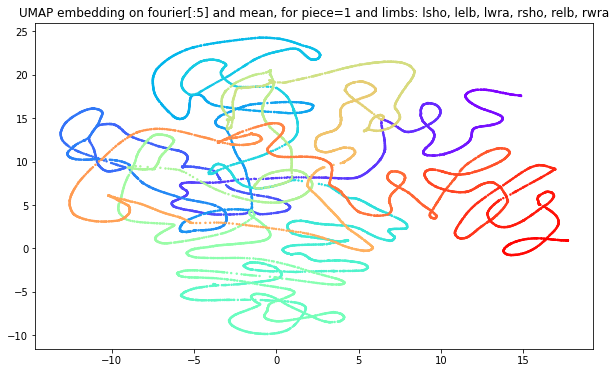

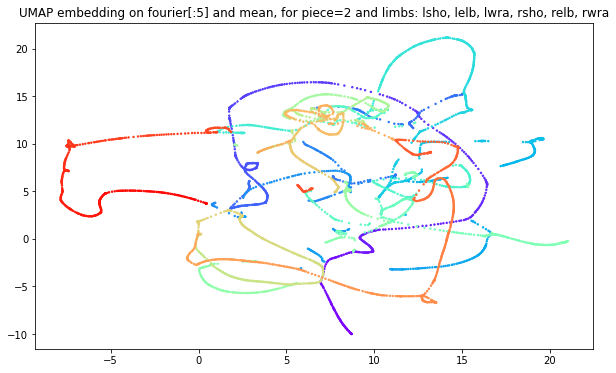

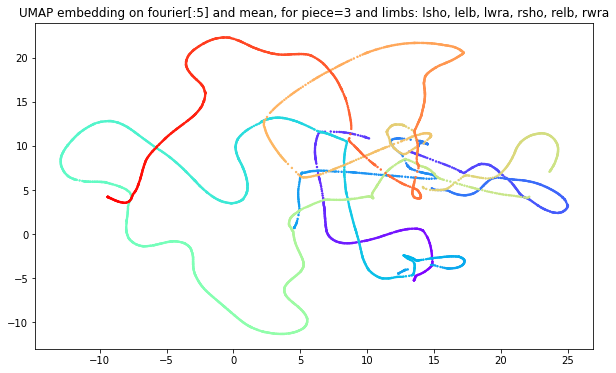

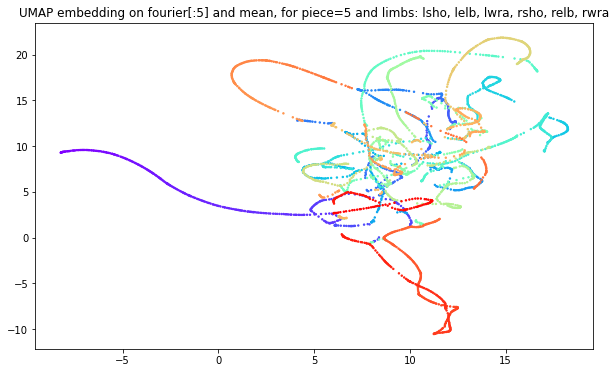

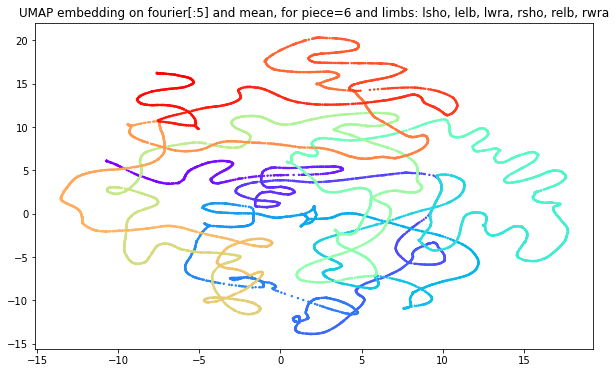

In [22]:
# Define the window size
ws = 500
perf = 1

for piece in [1,2,3,5,6]:
    embedding = umap2D(perf, piece, ws)
    colors = cm.rainbow(np.linspace(0, 1, len(embedding[:,0])))
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=2, color = colors)
    plt.title(f"UMAP embedding on fourier[:5] and mean, for {piece=} and limbs: lsho, lelb, lwra, rsho, relb, rwra")
    #plt.show()
    plt.savefig(f'wlen500_UMAP_fft_mean_piece{piece}.png')

In [23]:
def umap2D_nonfft(perf, piece, window_size):
    # Define the features to extract
    def extract_features(data):
        fourier_transform = np.abs(np.fft.fft(data)[:5])
        mean = np.mean(data, axis=-1)
        std = np.std(data, axis=-1)
        maximum = np.max(data, axis=-1)
        minimum = np.min(data, axis=-1)
        
        # Concatenate the features into a single array
        features = np.concatenate([mean, std, maximum, minimum], axis=0)
        return features

    # Load your time series data (assume it's in a numpy array of shape (n_samples, n_features))
    dataraw = np_piece_data_from_csv(perf, piece)
    lsho, lelb, lwra, rsho, relb, rwra = getDegrees2D(dataraw[0],dataraw[1], angLSHO), getDegrees2D(dataraw[0],dataraw[1], angLELB), getDegrees2D(dataraw[0],dataraw[1], angLWRA), getDegrees2D(dataraw[0],dataraw[1], angRSHO), getDegrees2D(dataraw[0],dataraw[1], angRELB), getDegrees2D(dataraw[0],dataraw[1], angRWRA)
    data = np.stack((lsho, lelb, lwra, rsho, relb, rwra), axis=1)


    # Create a sliding window and extract features for each window
    n_windows = data.shape[0] - window_size + 1
    windows = np.array([data[i:i+window_size] for i in range(n_windows)])
    features = np.array([extract_features(window) for window in windows])

    # Apply UMAP to reduce the dimensionality of the features into 2D space
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(features)
    return(embedding)


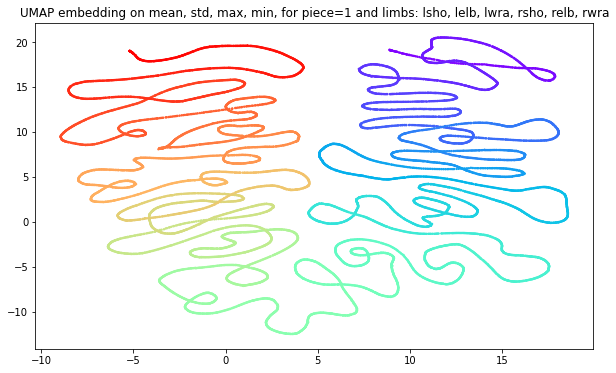

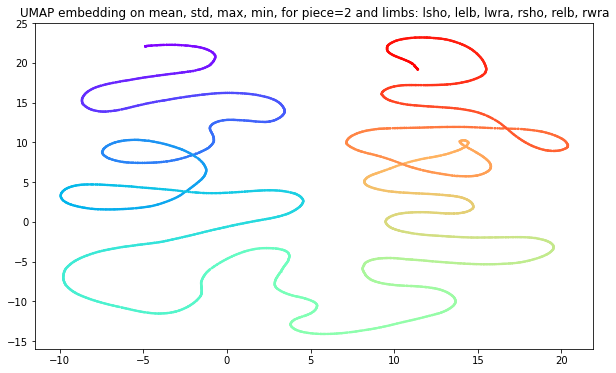

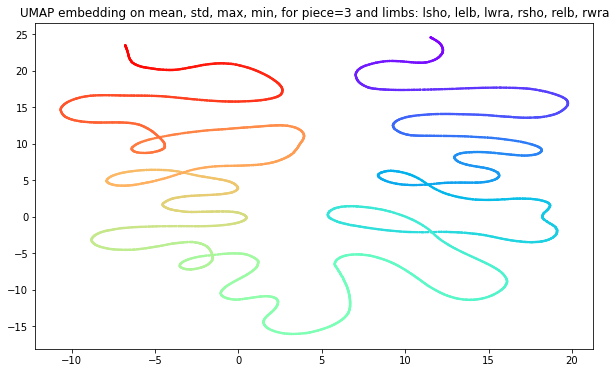

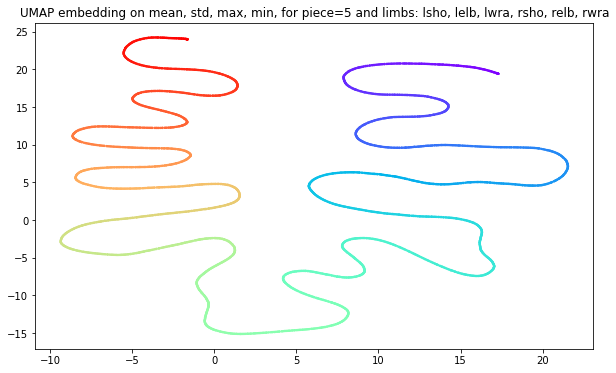

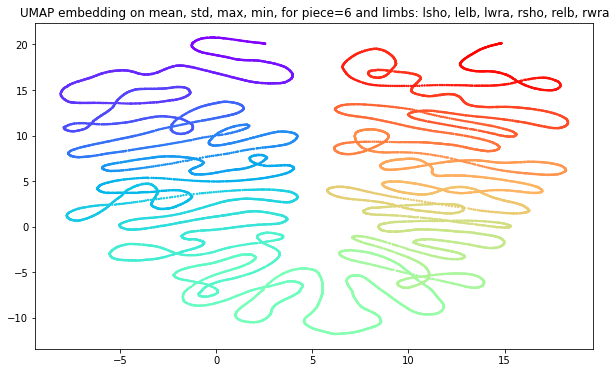

In [24]:
ws = 500
perf = 1

for piece in [1,2,3,5,6]:
    embedding = umap2D_nonfft(perf, piece, ws)
    colors = cm.rainbow(np.linspace(0, 1, len(embedding[:,0])))
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=2, color = colors)
    plt.title(f"UMAP embedding on mean, std, max, min, for {piece=} and limbs: lsho, lelb, lwra, rsho, relb, rwra")
    #plt.show()
    plt.savefig(f'wlen500_UMAP_angles_piece{piece}.png')

In [25]:

def umap2D_only_fft(perf, piece, window_size):
    # Define the features to extract
    def extract_features(data):
        fourier_transform = np.abs(np.fft.fft(data)[:5])
        features = np.concatenate(fourier_transform+ [1])
        return features

    # Load your time series data (assume it's in a numpy array of shape (n_samples, n_features))
    dataraw = np_piece_data_from_csv(perf, piece)
    lsho, lelb, lwra, rsho, relb, rwra = getDegrees2D(dataraw[0],dataraw[1], angLSHO), getDegrees2D(dataraw[0],dataraw[1], angLELB), getDegrees2D(dataraw[0],dataraw[1], angLWRA), getDegrees2D(dataraw[0],dataraw[1], angRSHO), getDegrees2D(dataraw[0],dataraw[1], angRELB), getDegrees2D(dataraw[0],dataraw[1], angRWRA)
    data = np.stack((lsho, lelb, lwra, rsho, relb, rwra), axis=1)


    # Create a sliding window and extract features for each window
    n_windows = data.shape[0] - window_size + 1
    windows = np.array([data[i:i+window_size] for i in range(n_windows)])
    features = np.array([extract_features(window) for window in windows])

    # Apply UMAP to reduce the dimensionality of the features into 2D space
    reducer = umap.UMAP(n_components=2)
    embedding = reducer.fit_transform(features)
    return(embedding)


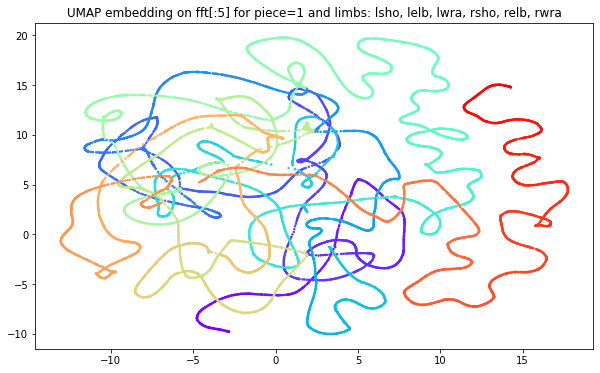

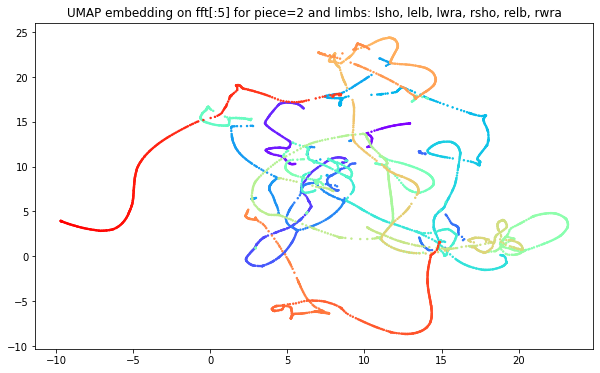

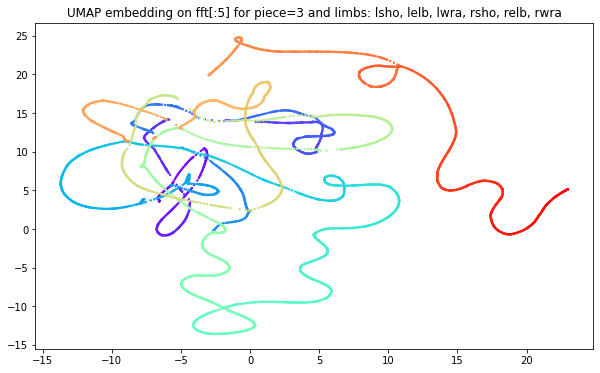

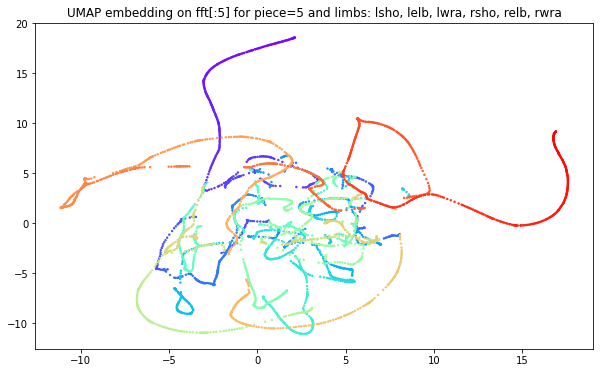

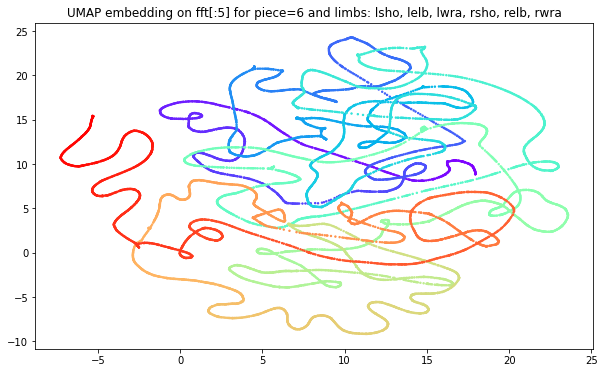

In [26]:
ws = 20
perf = 1

for piece in [1,2,3,5,6]:
    embedding = umap2D_only_fft(perf, piece, ws)
    colors = cm.rainbow(np.linspace(0, 1, len(embedding[:,0])))
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], s=2, color = colors)
    plt.title(f"UMAP embedding on fft[:5] for {piece=} and limbs: lsho, lelb, lwra, rsho, relb, rwra")
    #plt.show()
    plt.savefig(f'wlen500_UMAP_fft_piece{piece}.png')

In [27]:

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]


for piece in [1]:  # trial 
    for performance in range(1,7):
        p1 = np_piece_data_from_csv(performance,piece)

        angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to consider
        
        
        
        a1,a2,a3,a4,a5,a6 = getDegrees2D(p1[0], p1[1], angLST[0]),getDegrees2D(p1[0], p1[1], angLST[1]),getDegrees2D(p1[0], p1[1], angLST[2]),p.getDegrees2D(p1[0], p1[1], angLST[3]),p.getDegrees2D(p1[0], p1[1], angLST[4]),p.getDegrees2D(p1[0], p1[1], angLST[5])
        ars = t.callDeriv([a1,a2,a3,a4,a5,a6],smoothed=True) # get arrays of derivatives/time of each angle
        X = np.stack(ars, axis=0).T # X.shape too large! 
        X = res = X[::20,:] # let's reduce 20-fold

        y = np.arange(X.shape[0])

        # Fit and transform the data
        X_trans = reducer.fit_transform(X)
        print("check 2")
        # Check the shape of the new data
        print('Shape of X_trans: ', X_trans.shape)


        '''We can now use the chart plotting function we created earlier 
        to visualize our 3-dimensional digits data. We call the function 
        with a simple line of code passing the arrays we want to visualize.'''

        chart(X_trans, y)
        print("Done.")

NameError: name 'p' is not defined